# ML: Unsupervised algorithm - KMeans - Custoner segmentation

## Introduction

Customer segmentation is a tool widely used in marketing to group similar customers and thus be able to direct differentiated commercial policies by group in order to build loyalty and try to get them to move to more profitable groups for the company.

We will use the CRISP-DM methodology to assess the dataset and evaluate/obtain the conclusions/knowledge we are looking for.

### 1. Business understanding: 

Segment customers and profile each group and typify each of them.

### 2. Data understanding:
We have a file with customer data (Clientes_ns.csv) based on their sales history and with the following variables:

* ID: corresponds to the customer ID given by the company.
* Sex: customer's sex.
* Age: age of the customer.
* Income: income declared by the customer.
* Score: a score given by the company based on the customer's purchasing behaviour.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv('Clients_ns.csv', sep=';')
df.head()

,ID,Sexo,Edad,Ingresos,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        200 non-null    int64 
 1   Sexo      200 non-null    object
 2   Edad      200 non-null    int64 
 3   Ingresos  200 non-null    int64 
 4   Score     200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.duplicated().value_counts()

False    200
dtype: int64

In [5]:
df.nunique().sort_values()

Sexo          2
Edad         51
Ingresos     64
Score        84
ID          200
dtype: int64

In [6]:
df.isna().sum()

ID          0
Sexo        0
Edad        0
Ingresos    0
Score       0
dtype: int64

In [7]:
df.groupby(['Sexo']).describe().transpose()

Sexo                Female        Male
ID       count  112.000000   88.000000
         mean    97.562500  104.238636
         std     58.276412   57.483830
         min      3.000000    1.000000
         25%     46.750000   59.500000
         50%     94.500000  106.500000
         75%    148.250000  151.250000
         max    197.000000  200.000000
Edad     count  112.000000   88.000000
         mean    38.098214   39.806818
         std     12.644095   15.514812
         min     18.000000   18.000000
         25%     29.000000   27.750000
         50%     35.000000   37.000000
         75%     47.500000   50.500000
         max     68.000000   70.000000
Ingresos count  112.000000   88.000000
         mean    59.250000   62.227273
         std     26.011952   26.638373
         min     16.000000   15.000000
         25%     39.750000   45.500000
         50%     60.000000   62.500000
         75%     77.250000   78.000000
         max    126.000000  137.000000
Score    count  112.000000   88.000000
         mean    51.526786   48.511364
         std     24.114950   27.896770
         min      5.000000    1.000000
         25%     35.000000   24.500000
         50%     50.000000   50.000000
         75%     73.000000   70.000000
         max     99.000000   97.000000

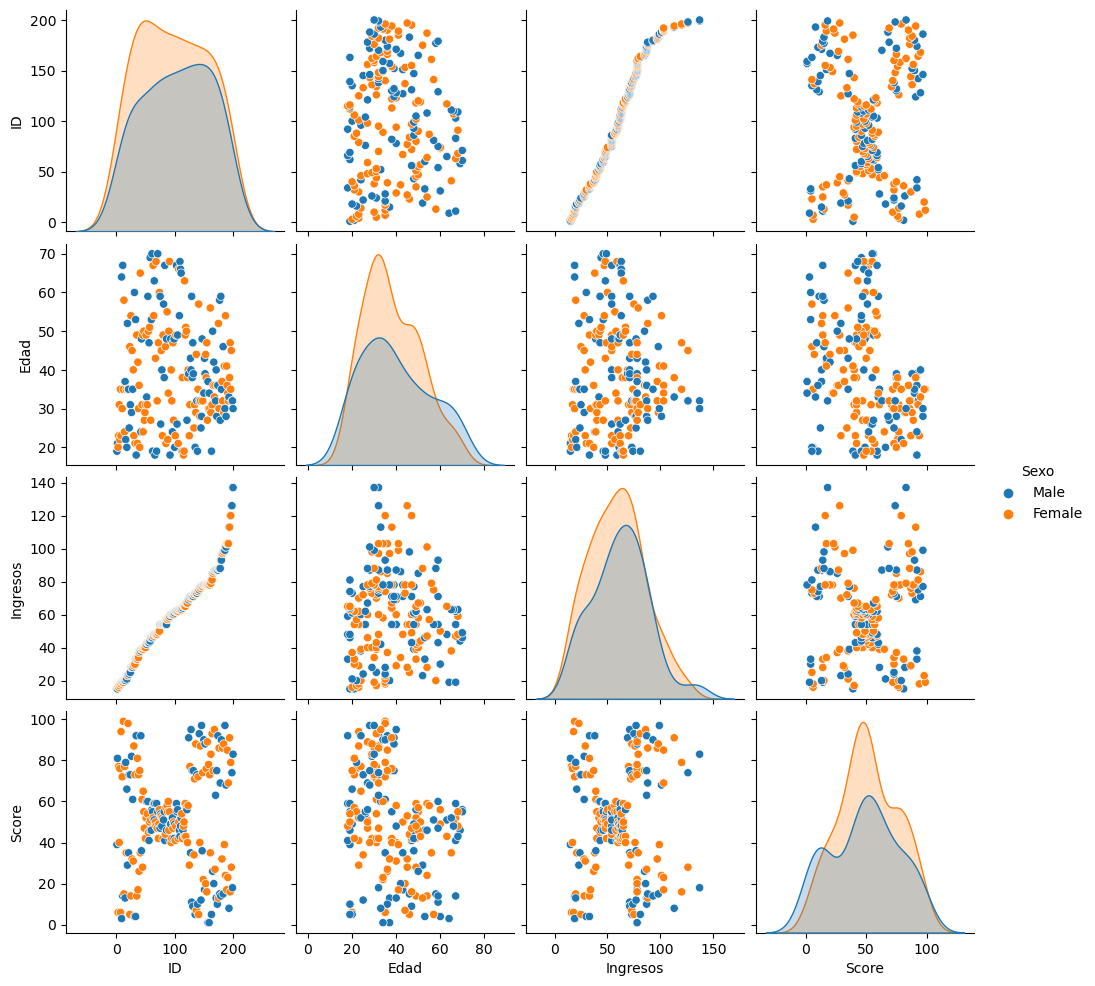

In [8]:
sns.pairplot(df, hue='Sexo')

__Conclusions__: 
* The dataset is clean and ready to use.
* We see linear correlations:
    * Ingresos-ID: apparently the dataset is sorted in increasing order of income.
* We see non-linear correlations:
    * Ingresos-Score
* Other patterns:
    * Female sex has higher mean score, but lower mean age and income.
* All variables are numerical except "Sexo", which is categorical and nominal.

### 3. Data preparation:

Since we have the categorical variable "Sexo" we will transform it into a numerical variable so that it can be treated in the model.

In [9]:
le=LabelEncoder()
df_prep=df.copy()
df_prep['Sexo_enc']=le.fit_transform(df_prep['Sexo'])
df_prep.head()

,ID,Sexo,Edad,Ingresos,Score,Sexo_enc
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


We remove the ID column as it does not provide the classification algorithm with relevant information for clustering.

In [10]:
df_prep.drop(columns=['ID'], inplace=True)

We select only the numeric columns.

In [11]:
df_prep=df_prep.select_dtypes(include='number')
df_prep.sample(5)

,Edad,Ingresos,Score,Sexo_enc
72,60,50,49,0
50,49,42,52,0
174,52,88,13,0
111,19,63,54,0
35,21,33,81,0


The variables have different scales and this, in an algorithm based on distances, can affect their weighting. Next we are going to standardise them (mean=0, sd=1), feature scaling processing, especially indicated for classification tasks, such as the one we want to carry out.

In [12]:
ss=StandardScaler()
df_scaled=ss.fit_transform(df_prep)
df_scaled=pd.DataFrame(df_scaled, columns=df_prep.columns)
df_scaled.sample(10)

,Edad,Ingresos,Score,Sexo_enc
161,-0.706902,0.703844,1.273347,-0.886405
14,-0.132768,-1.548152,-1.444162,1.128152
74,1.446099,-0.250391,-0.124229,1.128152
91,-1.496335,-0.059544,-0.357158,1.128152
108,2.091999,0.093133,-0.279515,1.128152
81,-0.061002,-0.250391,0.186343,1.128152
175,-0.635135,1.047369,1.389812,-0.886405
118,0.871965,0.245811,-0.279515,-0.886405
173,-0.204535,1.009200,1.622741,1.128152
179,-0.276302,1.238216,1.545098,1.128152


### 4. Modelling

Once the dataset has been prepared for the K-means model, we will carry out a battery of tests and through the metrics: elbow, solhouette and Calinski, we will evaluate the goodness of fit of the different models.

In [16]:
#We create the space for solutions
sol = list(range(2,20))
print(sol)

#We create several lists to store the output of each metric.
elbow = []
silhouette = []
calins = []

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


We will test the different solutions/nº of clusters proposed, and compare, with the aim of obtaining the best possible configuration.

In [17]:
#Probamos las diferentes soluciones
for solucion in sol:
    
    #Instanciar
    cluster = KMeans(random_state=14, n_clusters = solucion, n_init=20)
    
    #Entrenar
    cluster.fit(df_scaled)
    
    #Recoger las métricas
    elbow.append(cluster.inertia_)
    silhouette.append(silhouette_score(df_scaled, cluster.labels_))
    calins.append(calinski_harabasz_score(df_scaled, cluster.labels_))

    
metrics = pd.DataFrame({'Solucion':sol,
              'Elbow': elbow,
              'Silhouette':silhouette,
              'Calins':calins}).set_index('Solucion')
              

metrics

,Elbow,Silhouette,Calins
Solucion,,,
2,588.802677,0.251815,71.020516
3,476.787554,0.259513,66.772770
4,388.181668,0.299883,69.311527
5,325.628350,0.317377,71.018441
6,275.693295,0.319987,73.788882
7,236.663931,0.358911,76.566984
8,199.784782,0.387332,82.403904
9,174.119844,0.402972,85.819562
10,152.029834,0.420764,89.978196


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000264DB885508>,
      dtype=object)

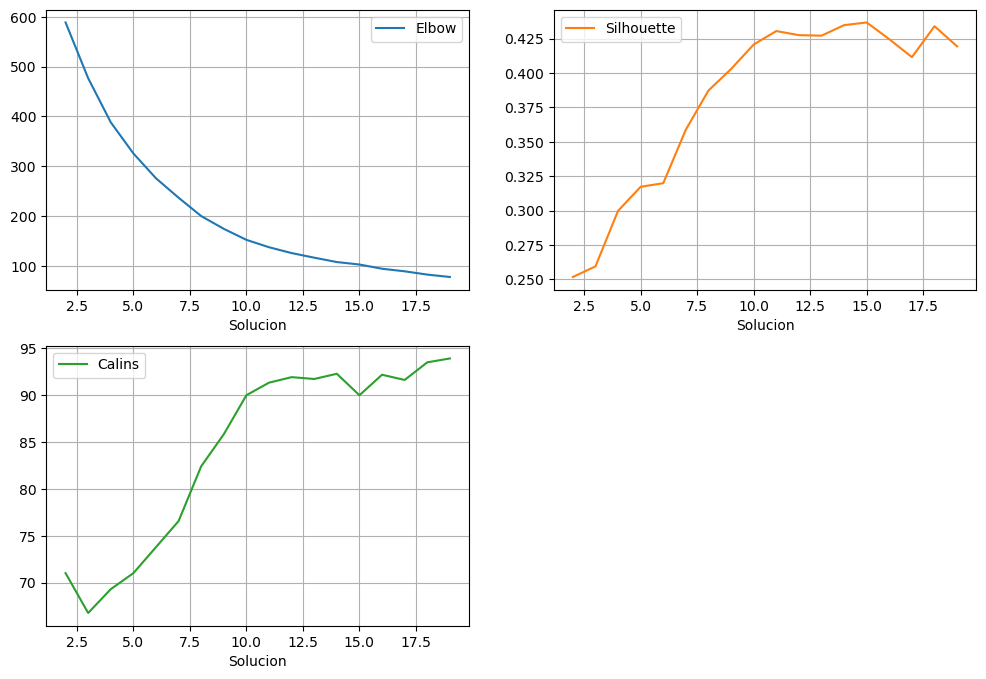

In [18]:
metrics.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False, grid=True)


It can be seen that the 3 metrics converge at around 10 and 12.
* Elbow method: the curve is not steep and therefore there is no clear point where there is an abrupt change in trend. We identify between K=10 and 12 a slope/gradient tending to the asymptote.
* Silhouette and Calinski method: around K=11 there is a first local maximum.

We will re-train the model for the chosen number of clusters and integrate the classification result into our dataset.

In [19]:
cluster = KMeans(random_state=14, n_clusters = 11, n_init=20)
cluster.fit(df_scaled)

KMeans(n_clusters=11, n_init=20, random_state=14)

In [20]:
df_predicted=df.copy()
df_predicted['Cluster']=cluster.predict(df_scaled)
df_predicted.sample(10)

,ID,Sexo,Edad,Ingresos,Score,Cluster
174,175,Female,52,88,13,0
198,199,Male,32,137,18,3
57,58,Male,69,44,46,7
170,171,Male,40,87,13,3
59,60,Male,53,46,46,7
74,75,Male,59,54,47,7
101,102,Female,49,62,48,8
136,137,Female,44,73,7,0
94,95,Female,32,60,42,10
102,103,Male,67,62,59,7


In [21]:
df_predicted.nunique()

ID          200
Sexo          2
Edad         51
Ingresos     64
Score        84
Cluster      11
dtype: int64

### 5. Evaluation

We will check the quality of the fit of the model by visualising the data through its original variables, and through a dimensional reduction, which being linear data, we will do by applying the PCA method.

In [22]:
df_predicted.groupby(['Cluster', 'Sexo']).agg({'Edad': ["median"],'Ingresos': "mean",'Score': "mean"})

,,Edad,Ingresos,Score
,,median,mean,mean
Cluster,Sexo,,,
0,Female,44.0,93.285714,20.642857
1,Male,32.0,87.111111,82.666667
2,Female,42.0,26.538462,20.692308
3,Male,41.0,85.150000,14.050000
4,Female,23.5,26.642857,79.142857
5,Male,56.5,24.000000,11.166667
6,Female,32.0,86.047619,81.666667
7,Male,59.0,53.571429,48.523810


In [23]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

In [24]:
df_pca=pd.DataFrame(df_pca, columns=['PC_1','PC_2'])
df_pca['Cluster']=df_predicted['Cluster']
df_pca.sample(5)

,PC_1,PC_2,Cluster
127,-0.876018,1.183114,1
184,0.188206,0.506253,0
68,-0.947390,0.523327,9
101,0.351736,-0.597959,8
48,-0.470519,-1.115774,10


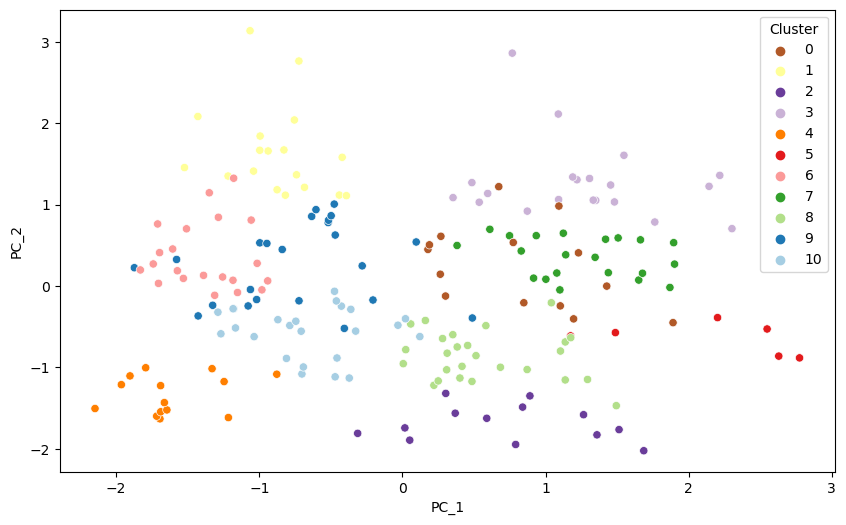

In [25]:
plt.figure(figsize=(10,6))
ax=sns.scatterplot(x = df_pca['PC_1'], y = df_pca['PC_2'], hue=df_pca['Cluster'], palette='Paired_r', legend='full')
plt.show()

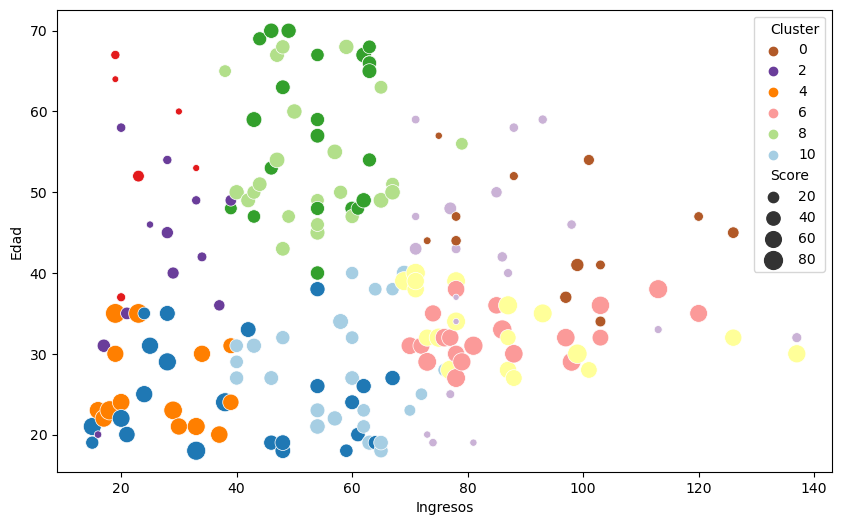

In [26]:
plt.figure(figsize=(10,6))
ax=sns.scatterplot(x = df_predicted['Ingresos'], y = df_predicted['Edad'], hue=df_predicted['Cluster'], size=df_predicted['Score'], palette='Paired_r', sizes=(20, 200))
plt.show()

Below are details of the profile segmentation carried out, this being the final objective of the study.

In [27]:
df_predicted.groupby(['Cluster', 'Sexo']).agg({'Edad': ['count',"median"],'Ingresos': "mean",'Score': "mean"}).sort_values('Sexo')

Edad          Ingresos      Score
               count median       mean       mean
Cluster Sexo                                     
0       Female    14   44.0  93.285714  20.642857
2       Female    13   42.0  26.538462  20.692308
4       Female    14   23.5  26.642857  79.142857
6       Female    21   32.0  86.047619  81.666667
8       Female    26   50.5  54.230769  48.961538
10      Female    24   27.0  58.125000  46.541667
1       Male      18   32.0  87.111111  82.666667
3       Male      20   41.0  85.150000  14.050000
5       Male       6   56.5  24.000000  11.166667
7       Male      21   59.0  53.571429  48.523810
9       Male      23   24.0  40.695652  61.478261

In [28]:
df_predicted['Edad'].mean()

38.85

__Conclusions/Evaluation/Insight__:
* The model has been able to make a separation by gender.
* In relation to the profiles, it is worth mentioning:
    * Cluster 1 and 6: men and women in their 30s, well-valued and with high incomes.
    * Cluster 0 and 3: men and women around 40, with high incomes but poorly valued. 

### 6. Deployment

Although this phase is not applicable, it is worth mentioning as the last stage of the CRISP-DM process.  
In this step, if appropriate, the code would be cleaned/factored for production. 